### 2. Dogs vs. Cats

Make a convolutional neural network (CNN) classifier for classifying dogs and cats.

The complete dataset is from Kaggle (https://www.kaggle.com/c/dogs-vs-cats/data), containing 25,000 images of dogs and cats. Since the dataset is too large, I have reduced it to a smaller dataset that can run successfully on a limited GPU laptop. The small dataset includes:

- 2,000 images in the train folder (1,000 cats and 1,000 dogs),
- 1,000 images in the validation folder (500 cats and 500 dogs),
- 1,000 images in the test folder (500 cats and 500 dogs).

Requirements:

- Comment your code well, explaining each step.
- Report the classification error/accuracy.
- Submit a program code(s).

Please note that distinguishing between dogs and cats has been a long-standing challenge for computers, even though a small child can easily do this. Only recently have computers achieved performance comparable to humans. Therefore, do not get discouraged if you do not obtain optimal results.




In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import os
from tqdm import tqdm


In [5]:
!unzip cat_dog_small_dataset.zip

Archive:  cat_dog_small_dataset.zip
   creating: cat_dog_small_dataset/
   creating: cat_dog_small_dataset/test/
   creating: cat_dog_small_dataset/test/cats/
  inflating: cat_dog_small_dataset/test/cats/cat.1500.jpg  
  inflating: cat_dog_small_dataset/test/cats/cat.1501.jpg  
  inflating: cat_dog_small_dataset/test/cats/cat.1502.jpg  
  inflating: cat_dog_small_dataset/test/cats/cat.1503.jpg  
  inflating: cat_dog_small_dataset/test/cats/cat.1504.jpg  
  inflating: cat_dog_small_dataset/test/cats/cat.1505.jpg  
  inflating: cat_dog_small_dataset/test/cats/cat.1506.jpg  
  inflating: cat_dog_small_dataset/test/cats/cat.1507.jpg  
  inflating: cat_dog_small_dataset/test/cats/cat.1508.jpg  
  inflating: cat_dog_small_dataset/test/cats/cat.1509.jpg  
  inflating: cat_dog_small_dataset/test/cats/cat.1510.jpg  
  inflating: cat_dog_small_dataset/test/cats/cat.1511.jpg  
  inflating: cat_dog_small_dataset/test/cats/cat.1512.jpg  
  inflating: cat_dog_small_dataset/test/cats/cat.1513.jpg  
 

In [6]:
# Paths to the dataset
data_dir = './cat_dog_small_dataset'
train_dir = os.path.join(data_dir, 'train')
valid_dir = os.path.join(data_dir, 'validation')
test_dir = os.path.join(data_dir, 'test')


In [7]:
# Data transformations: resize, normalize, and augment the data
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((150, 150)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'validation': transforms.Compose([
        transforms.Resize((150, 150)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((150, 150)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


In [8]:
# Load datasets
image_datasets = {
    'train': datasets.ImageFolder(train_dir, transform=data_transforms['train']),
    'validation': datasets.ImageFolder(valid_dir, transform=data_transforms['validation']),
    'test': datasets.ImageFolder(test_dir, transform=data_transforms['test'])
}

# Create data loaders
dataloaders = {
    'train': DataLoader(image_datasets['train'], batch_size=32, shuffle=True),
    'validation': DataLoader(image_datasets['validation'], batch_size=32, shuffle=False),
    'test': DataLoader(image_datasets['test'], batch_size=32, shuffle=False)
}

# Use a pretrained model (ResNet18) and modify it for binary classification
model = models.resnet18(pretrained=True) ###  Here,you can change other Pretrained model. Ref:https://pytorch.org/vision/stable/models.html
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)  # Two output classes: cat and dog

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 119MB/s]


In [11]:
from tqdm import tqdm

# Training function with alternating training and validation phases per epoch
def train_model(model, criterion, optimizer, num_epochs=1):
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print("-" * 10)

        # Training phase
        model.train()  # Set model to training mode
        running_loss = 0.0
        running_corrects = 0
        total_samples = 0  # Track total number of samples processed

        # Training progress bar
        progress_bar = tqdm(dataloaders['train'], desc="Training Progress")
        for inputs, labels in progress_bar:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            with torch.set_grad_enabled(True):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                # Backward pass + optimize
                loss.backward()
                optimizer.step()

            # Statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            total_samples += labels.size(0)

            # Update progress bar with train loss and accuracy
            progress_bar.set_postfix({
                'Train Loss': running_loss / total_samples,
                'Train Accuracy': running_corrects.double() / total_samples
            })

        # Final training loss and accuracy for the epoch
        train_loss = running_loss / len(image_datasets['train'])
        train_acc = running_corrects.double() / len(image_datasets['train'])
        print(f"Train Loss: {train_loss:.4f} Train Accuracy: {train_acc:.4f}")

        # Validation phase
        model.eval()  # Set model to evaluation mode
        running_loss = 0.0
        running_corrects = 0
        total_samples = 0

        # Validation progress bar
        progress_bar = tqdm(dataloaders['validation'], desc="Validation Progress")
        with torch.no_grad():  # Disable gradient calculation during validation
            for inputs, labels in progress_bar:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                total_samples += labels.size(0)

                # Update progress bar with validation loss and accuracy
                progress_bar.set_postfix({
                    'Validation Loss': running_loss / total_samples,
                    'Validation Accuracy': running_corrects.double() / total_samples
                })

        # Final validation loss and accuracy for the epoch
        val_loss = running_loss / len(image_datasets['validation'])
        val_acc = running_corrects.double() / len(image_datasets['validation'])
        print(f"Validation Loss: {val_loss:.4f} Validation Accuracy: {val_acc:.4f}")

        print()

    print("Training complete")

# Train the model
train_model(model, criterion, optimizer, num_epochs=5)


Epoch 1/5
----------


Training Progress: 100%|██████████| 63/63 [04:39<00:00,  4.44s/it, Train Loss=0.251, Train Accuracy=tensor(0.9000, dtype=torch.float64)]


Train Loss: 0.2509 Train Accuracy: 0.9000


Validation Progress: 100%|██████████| 32/32 [00:49<00:00,  1.53s/it, Validation Loss=0.226, Validation Accuracy=tensor(0.8930, dtype=torch.float64)]


Validation Loss: 0.2256 Validation Accuracy: 0.8930

Epoch 2/5
----------


Training Progress: 100%|██████████| 63/63 [04:34<00:00,  4.35s/it, Train Loss=0.134, Train Accuracy=tensor(0.9515, dtype=torch.float64)]


Train Loss: 0.1343 Train Accuracy: 0.9515


Validation Progress: 100%|██████████| 32/32 [00:47<00:00,  1.48s/it, Validation Loss=0.205, Validation Accuracy=tensor(0.9220, dtype=torch.float64)]


Validation Loss: 0.2048 Validation Accuracy: 0.9220

Epoch 3/5
----------


Training Progress: 100%|██████████| 63/63 [04:34<00:00,  4.35s/it, Train Loss=0.143, Train Accuracy=tensor(0.9420, dtype=torch.float64)]


Train Loss: 0.1434 Train Accuracy: 0.9420


Validation Progress: 100%|██████████| 32/32 [00:49<00:00,  1.55s/it, Validation Loss=0.32, Validation Accuracy=tensor(0.8700, dtype=torch.float64)]


Validation Loss: 0.3202 Validation Accuracy: 0.8700

Epoch 4/5
----------


Training Progress: 100%|██████████| 63/63 [04:36<00:00,  4.38s/it, Train Loss=0.127, Train Accuracy=tensor(0.9565, dtype=torch.float64)]


Train Loss: 0.1271 Train Accuracy: 0.9565


Validation Progress: 100%|██████████| 32/32 [00:45<00:00,  1.42s/it, Validation Loss=0.182, Validation Accuracy=tensor(0.9290, dtype=torch.float64)]


Validation Loss: 0.1821 Validation Accuracy: 0.9290

Epoch 5/5
----------


Training Progress: 100%|██████████| 63/63 [04:29<00:00,  4.27s/it, Train Loss=0.0992, Train Accuracy=tensor(0.9635, dtype=torch.float64)]


Train Loss: 0.0992 Train Accuracy: 0.9635


Validation Progress: 100%|██████████| 32/32 [00:48<00:00,  1.52s/it, Validation Loss=0.286, Validation Accuracy=tensor(0.8870, dtype=torch.float64)]

Validation Loss: 0.2856 Validation Accuracy: 0.8870

Training complete


In [12]:
# Test the model
def test_model(model, criterion):
    model.eval()  # Set model to evaluation mode
    running_corrects = 0
    running_loss = 0.0

    misclassified_images = []
    misclassified_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(dataloaders['test'], desc="Testing Progress"):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            # Accumulate statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

            # Collect misclassified examples
            for i in range(len(preds)):
                if preds[i] != labels[i]:
                    misclassified_images.append(inputs[i].cpu())
                    misclassified_labels.append((preds[i].item(), labels[i].item()))

    test_loss = running_loss / len(image_datasets['test'])
    test_acc = running_corrects.double() / len(image_datasets['test'])

    print(f"Test Loss: {test_loss:.4f} Acc: {test_acc:.4f}")

    return misclassified_images, misclassified_labels

# Run the testing phase and retrieve misclassified images
misclassified_images, misclassified_labels = test_model(model, criterion)


Testing Progress: 100%|██████████| 32/32 [00:56<00:00,  1.77s/it]

Test Loss: 0.2980 Acc: 0.8890


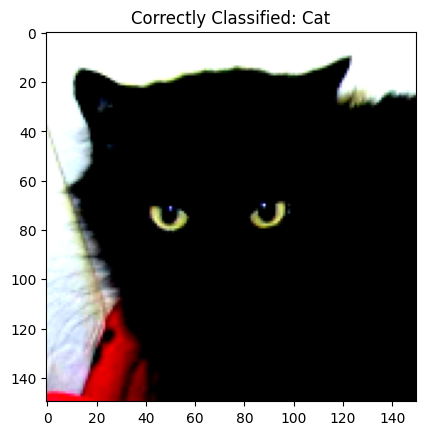

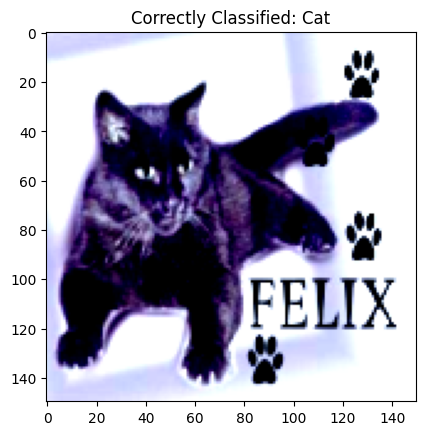

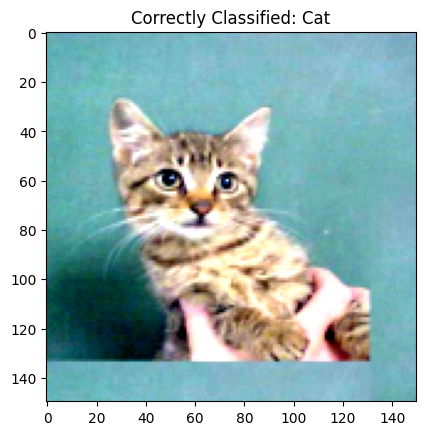

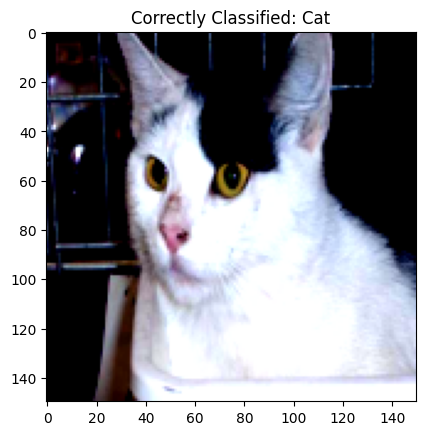

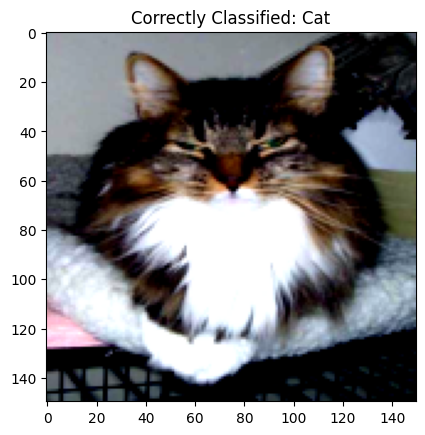

In [14]:
# Display a few correctly classified images
def imshow(img, title):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy().transpose((1, 2, 0))
    plt.imshow(npimg)
    plt.title(title)
    plt.show()

# List to store correctly classified images and labels
correctly_classified_images = []
correctly_classified_labels = []

# Loop over the test data and collect correctly classified examples
with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        # Collect correctly classified images and labels
        for i in range(len(preds)):
            if preds[i] == labels[i]:  # Check if the prediction is correct
                correctly_classified_images.append(inputs[i].cpu())  # Move tensor to CPU for display
                correctly_classified_labels.append(preds[i].item())  # Store the predicted label

# Visualize the first few correctly classified images
for i in range(min(len(correctly_classified_images), 5)):
    label = 'Dog' if correctly_classified_labels[i] == 1 else 'Cat'
    title = f"Correctly Classified: {label}"
    imshow(correctly_classified_images[i], title)


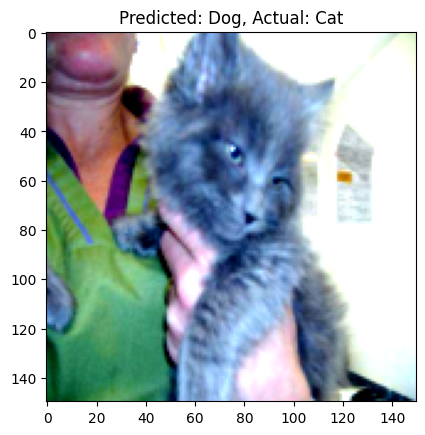

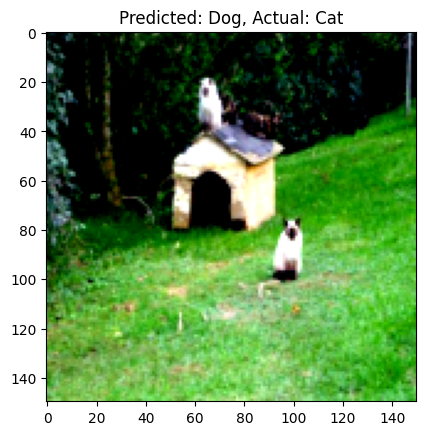

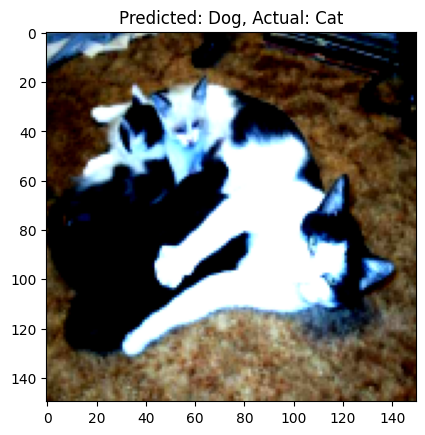

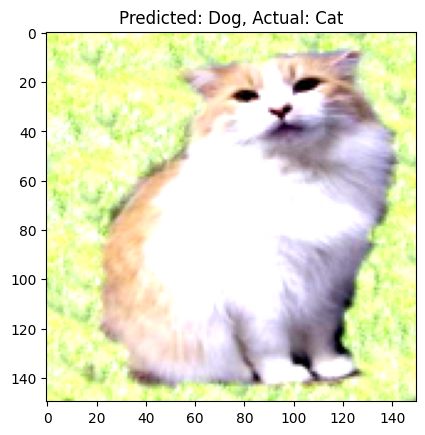

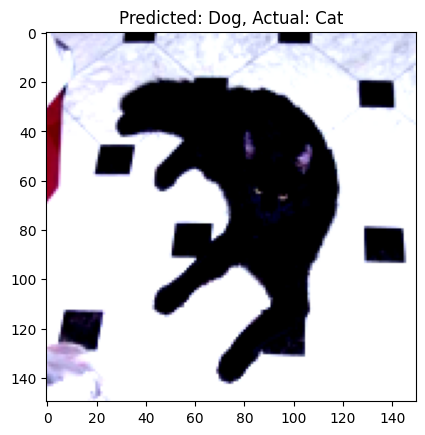

In [13]:
# Display a few misclassified images
def imshow(img, title):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy().transpose((1, 2, 0))
    plt.imshow(npimg)
    plt.title(title)
    plt.show()

# Visualize the first few misclassified images
for i in range(min(len(misclassified_images), 5)):
    title = f"Predicted: {'Dog' if misclassified_labels[i][0] == 1 else 'Cat'}, Actual: {'Dog' if misclassified_labels[i][1] == 1 else 'Cat'}"
    imshow(misclassified_images[i], title)